# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os


In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 200000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (200000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(160178, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

80.089

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(160176, 10)


1    134799
0     25377
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.
The qualitys not as good as the lamb and rice but it didn't seem to bother his stomach, you get 10 more pounds and it is cheaper wich is a plus for me. You can always ad your own rice and veggies. Its fresher that way and better for him in my opinion. Plus if you you can get it deliverd to your house for free its even better.  Gotta love pitbulls
This is the Japanese version of breadcrumb (pan=bread, a Portuguese loan-word, and&quot;ko-&quot;  is &quot;child of&quot; or of &quot;derived from&quot;.) Panko are used for katsudon, tonkatsu or cutlets served on rice or in soups. The cutlets, pounded chicken or pork, are coated with these light and crispy crumbs and fried. They are not gritty and dense like regular crumbs. They are very nice on deep fried shrimps and decorative for a more g

In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.
The qualitys not as good as the lamb and rice but it didn't seem to bother his stomach, you get 10 more pounds and it is cheaper wich is a plus for me. You can always ad your own rice and veggies. Its fresher that way and better for him in my opinion. Plus if you you can get it deliverd to your house for free its even better.  Gotta love pitbulls
This is the Japanese version of breadcrumb (pan=bread, a Portuguese loan-word, and"ko-"  is "child of" or of "derived from".) Panko are used for katsudon, tonkatsu or cutlets served on rice or in soups. The cutlets, pounded chicken or pork, are coated with these light and crispy crumbs and fried. They are not gritty and dense like regular crumbs. They are very nice on deep fried shrimps and decorative for a more gourmet touch.
What can I say..

In [18]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This is the Japanese version of breadcrumb (pan=bread, a Portuguese loan-word, and&quot;ko-&quot;  is &quot;child of&quot; or of &quot;derived from&quot;.) Panko are used for katsudon, tonkatsu or cutlets served on rice or in soups. The cutlets, pounded chicken or pork, are coated with these light and crispy crumbs and fried. They are not gritty and dense like regular crumbs. They are very nice on deep fried shrimps and decorative for a more gourmet touch.


In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This is the Japanese version of breadcrumb pan bread a Portuguese loan word and quot ko quot is quot child of quot or of quot derived from quot Panko are used for katsudon tonkatsu or cutlets served on rice or in soups The cutlets pounded chicken or pork are coated with these light and crispy crumbs and fried They are not gritty and dense like regular crumbs They are very nice on deep fried shrimps and decorative for a more gourmet touch 


In [22]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 160176/160176 [01:58<00:00, 1355.95it/s]


In [24]:
preprocessed_reviews[1500]

'japanese version breadcrumb pan bread portuguese loan word ko child derived panko used katsudon tonkatsu cutlets served rice soups cutlets pounded chicken pork coated light crispy crumbs fried not gritty dense like regular crumbs nice deep fried shrimps decorative gourmet touch'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [25]:
# preprocessing for review summary.
# printing some random reviews
sent_0 = final['Summary'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Summary'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Summary'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Summary'].values[4900]
print(sent_4900)
print("="*50)

A classic
Diamond dog food
Essential for Tonkatsu, etc
Better to the last drop


In [26]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

A classic


In [27]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

A classic
Diamond dog food
Essential for Tonkatsu, etc
Better to the last drop


In [28]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [29]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)


Essential for Tonkatsu, etc


In [30]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

A classic


In [31]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Essential for Tonkatsu etc


In [32]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [33]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 160176/160176 [01:22<00:00, 1940.12it/s]


In [34]:
preprocessed_summary[15000]

'favorite tea whole world'

In [35]:
preprocessed_RevSum = preprocessed_reviews+preprocessed_summary

# [5] Assignment 9: Random Forests

<ol>
    <li><strong>Apply Random Forests & GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (Consider two hyperparameters: n_estimators & max_depth)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 20 important features and represent them in a word cloud. Do this for BOW & TFIDF.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='3d_plot.JPG' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>(or)</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='heat_map.JPG' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying RF

### [5.1.1] Applying Random Forests on BOW,<font color='red'> SET 1</font>

In [165]:
#For Feature Engineering
df1 = pd.DataFrame(preprocessed_RevSum)

In [166]:
docs =preprocessed_RevSum
data = []
for d in docs:
    
    data.append(len(d))

In [167]:
df1['length'] = data

In [168]:
df1.head(5)

,0,length
0,remembered book childhood got kids good rememb...,114
1,daughter loves really rosie books introduced r...,285
2,one best children books ever written mini vers...,144
3,entertaining rhyming story cleaver catchy illu...,142
4,grand daughter favorite book read loves rhythm...,80


In [169]:
df1 = df1.rename(columns = {0 : 'preprocessed_RevSum'})
df1.head(3)

,preprocessed_RevSum,length
0,remembered book childhood got kids good rememb...,114
1,daughter loves really rosie books introduced r...,285
2,one best children books ever written mini vers...,144


In [170]:
X=df1[:100000]
PosNeg = final['Score']
y=PosNeg[:100000]


In [171]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.metrics import roc_auc_score

In [172]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate




In [173]:
# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=42)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

In [174]:
#performing bow
print(X_tr.shape, y_tr.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)



from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4))
vectorizer.fit(X_tr['preprocessed_RevSum'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_tr['preprocessed_RevSum'].values)
X_cv_bow = vectorizer.transform(X_cv['preprocessed_RevSum'].values)
X_test_bow = vectorizer.transform(X_test['preprocessed_RevSum'].values)

print("After vectorizations")
print(X_train_bow.shape, y_tr.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)


(49000, 2) (49000,)
(21000, 2) (21000,)
(30000, 2) (30000,)
After vectorizations
(49000, 30250) (49000,)
(21000, 30250) (21000,)
(30000, 30250) (30000,)


In [175]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_tr['length'].values.reshape(-1,1))

X_train_price_norm = normalizer.transform(X_tr['length'].values.reshape(-1,1))
X_cv_price_norm = normalizer.transform(X_cv['length'].values.reshape(-1,1))
X_test_price_norm = normalizer.transform(X_test['length'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_price_norm.shape, y_tr.shape)
print(X_cv_price_norm.shape, y_cv.shape)
print(X_test_price_norm.shape, y_test.shape)

After vectorizations
(49000, 1) (49000,)
(21000, 1) (21000,)
(30000, 1) (30000,)


*Feature Engineering*

In [176]:
# Feature Engineering
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr_bow = hstack((X_train_bow,X_train_price_norm)).tocsr()
X_cv_bow = hstack((X_cv_bow, X_cv_price_norm)).tocsr()
X_test_bow = hstack((X_test_bow, X_test_price_norm)).tocsr()

print("Final Data matrix")
print(X_tr_bow.shape, y_tr.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)

Final Data matrix
(49000, 30251) (49000,)
(21000, 30251) (21000,)
(30000, 30251) (30000,)


In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

base_learners = [5,10,50,100,200,500,1000]
depth = [1,5,10,15,20,25,30]
tuned_parameters = {'n_estimators': base_learners,'max_depth': depth}
RF = RandomForestClassifier(max_features='sqrt',class_weight = 'balanced')
model = GridSearchCV(RF, tuned_parameters, scoring = 'roc_auc', cv=5 , n_jobs = -1)
model.fit(X_tr_bow, y_tr)


print(model.best_estimator_)
print("AUC is ",model.score(X_test_bow, y_test))



RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=25, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
AUC is  0.9329716312329152


In [49]:
# Optimal value of number of base learners
optimal_learners = model.best_estimator_.n_estimators
print("The optimal number of base learners is : ",optimal_learners)

optimal_depth=model.best_estimator_.max_depth
print("The optimal number of depth is : ",optimal_depth)

The optimal number of base learners is :  1000
The optimal number of depth is :  25


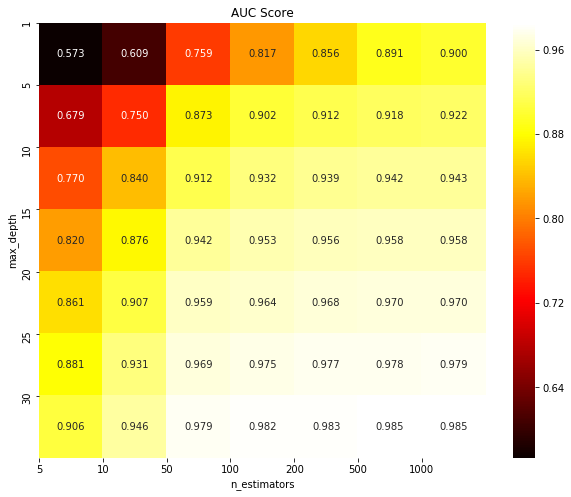

In [50]:
# heat map for train data.#https://github.com/sai977/amazon-fine-food-reviews/blob/master/Amazon%20Fine%20Food%20Reviews%20Analysis%20rf%20and%20gbdt1.ipynb
import seaborn as sns

scores = model.cv_results_['mean_train_score'].reshape(len(base_learners),len(depth))
plt.figure(figsize=(10,8))

sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=base_learners, yticklabels=depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(base_learners)), base_learners)
plt.yticks(np.arange(len(depth)), depth)
plt.title('AUC Score')
plt.show()

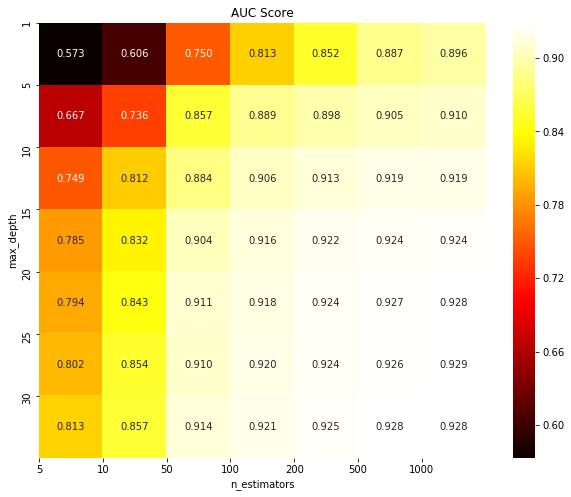

In [51]:
#heatmap for cv data.#https://github.com/sai977/amazon-fine-food-reviews/blob/master/Amazon%20Fine%20Food%20Reviews%20Analysis%20rf%20and%20gbdt1.ipynb
import seaborn as sns

scores = model.cv_results_['mean_test_score'].reshape(len(base_learners),len(depth))
plt.figure(figsize=(10, 8))

sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=base_learners, yticklabels=depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(base_learners)), base_learners)
plt.yticks(np.arange(len(depth)), depth)
plt.title('AUC Score')
plt.show()

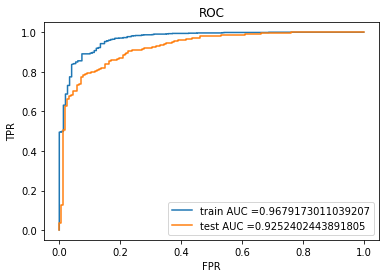

Train confusion matrix
[[ 6245  1138]
 [ 1645 39972]]
Test confusion matrix
[[ 3243  1260]
 [ 1525 23972]]


In [52]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
RF = RandomForestClassifier(max_features='sqrt',class_weight = 'balanced',n_estimators =optimal_learners,max_depth = optimal_depth )
RF.fit(X_tr_bow,y_tr)    



for i in range(0,X_tr_bow.shape[0],1000):
    train_fpr, train_tpr, thresholds = roc_curve(y_tr[i:i+1000], RF.predict_proba(X_tr_bow[i:i+1000])[:,1])

for i in range(0,X_test_bow.shape[0],1000):
    test_fpr, test_tpr, thresholds = roc_curve(y_test[i:i+1000], RF.predict_proba(X_test_bow[i:i+1000])[:,1])    

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_tr, RF.predict(X_tr_bow)))
print("Test confusion matrix")
print(confusion_matrix(y_test, RF.predict(X_test_bow)))

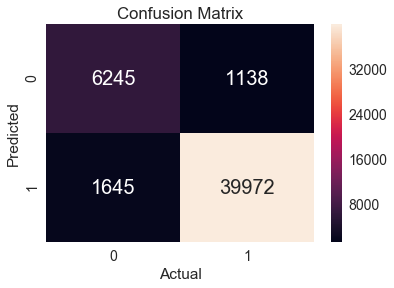

In [53]:
confusion_mtx = pd.DataFrame(confusion_matrix(y_tr, RF.predict(X_tr_bow)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion_mtx, annot=True,annot_kws={"size": 20}, fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

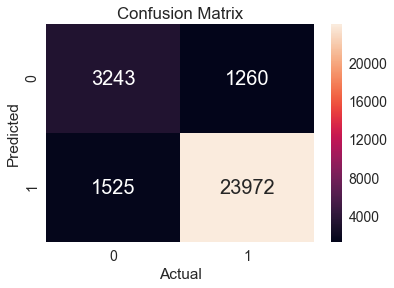

In [54]:
confusion_mtx = pd.DataFrame(confusion_matrix(y_test, RF.predict(X_test_bow)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion_mtx, annot=True,annot_kws={"size": 20}, fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

### [5.1.2] Wordcloud of top 20 important features from<font color='red'> SET 1</font>

In [55]:
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

feature_names = vectorizer.get_feature_names()
coefs = sorted(zip(RF.feature_importances_, feature_names))
top = coefs[:-(20 + 1):-1]
for (coef_2, fn_2) in top:
    print("%s    <---------------->     %s"%(coef_2, fn_2))


0.028392611880544694    <---------------->     not
0.025654360045735583    <---------------->     great
0.014873803528280853    <---------------->     best
0.012639015410683359    <---------------->     love
0.011659050264097946    <---------------->     disappointed
0.010627310364665868    <---------------->     bad
0.010361202212638702    <---------------->     perfect
0.00978074653096949    <---------------->     delicious
0.009315870592833283    <---------------->     would
0.009227548002273942    <---------------->     money
0.008960264178160756    <---------------->     not buy
0.0076748959471459426    <---------------->     waste
0.007670404557804241    <---------------->     loves
0.007627794494044758    <---------------->     thought
0.007378336595367416    <---------------->     awful
0.007358684958277228    <---------------->     worst
0.0068769342788360084    <---------------->     would not
0.006874150965276733    <---------------->     terrible
0.00612649196632935    <---

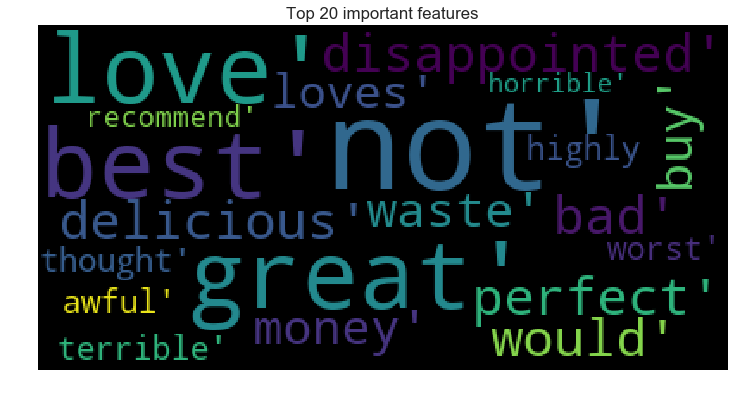

In [56]:
from wordcloud import WordCloud
wordcloud = WordCloud(collocations=False, background_color ='black', 
                min_font_size = 10).generate(str(list(top)))
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Top 20 important features")
plt.show() 

### [5.1.3] Applying Random Forests on TFIDF,<font color='red'> SET 2</font>

In [186]:
print(X_tr.shape, y_tr.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)



tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10,dtype=np.float64)
tf_idf_vect.fit(X_tr['preprocessed_RevSum'].values)
X_tr_tfidf= tf_idf_vect.transform(X_tr['preprocessed_RevSum'].values)
X_cv_tfidf = tf_idf_vect.transform(X_cv['preprocessed_RevSum'].values)
X_test_tfidf = tf_idf_vect.transform(X_test['preprocessed_RevSum'].values)
print("After vectorizations")
print(X_tr_tfidf.shape, y_tr.shape)
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)
print("="*100)


(49000, 2) (49000,)
(21000, 2) (21000,)
(30000, 2) (30000,)
After vectorizations
(49000, 27968) (49000,)
(21000, 27968) (21000,)
(30000, 27968) (30000,)


In [187]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_tr['length'].values.reshape(-1,1))

X_train_price_norm = normalizer.transform(X_tr['length'].values.reshape(-1,1))
X_cv_price_norm = normalizer.transform(X_cv['length'].values.reshape(-1,1))
X_test_price_norm = normalizer.transform(X_test['length'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_price_norm.shape, y_tr.shape)
print(X_cv_price_norm.shape, y_cv.shape)
print(X_test_price_norm.shape, y_test.shape)

After vectorizations
(49000, 1) (49000,)
(21000, 1) (21000,)
(30000, 1) (30000,)


In [188]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr_tfidf = hstack((X_tr_tfidf,X_train_price_norm)).tocsr()
X_cv_tfidf = hstack((X_cv_tfidf, X_cv_price_norm)).tocsr()
X_test_tfidf = hstack((X_test_tfidf, X_test_price_norm)).tocsr()

print("Final Data matrix")
print(X_tr_tfidf.shape, y_tr.shape)
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)

Final Data matrix
(49000, 27969) (49000,)
(21000, 27969) (21000,)
(30000, 27969) (30000,)


In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

base_learners = [5,10,50,100,200,500,1000]
depth = [1,5,10,15,20,25,30]
tuned_parameters = {'n_estimators': base_learners,'max_depth': depth}
RF = RandomForestClassifier(max_features='sqrt',class_weight = 'balanced')
model = GridSearchCV(RF, tuned_parameters, scoring = 'roc_auc', cv=5 , n_jobs = -1)
model.fit(X_tr_tfidf, y_tr)


print(model.best_estimator_)
print("AUC is ",model.score(X_test_tfidf, y_test))

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=30, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
AUC is  0.936258606833089


In [61]:
# Optimal value of number of base learners
optimal_learners = model.best_estimator_.n_estimators
print("The optimal number of base learners is : ",optimal_learners)

optimal_depth=model.best_estimator_.max_depth
print("The optimal number of depth is : ",optimal_depth)

The optimal number of base learners is :  1000
The optimal number of depth is :  30


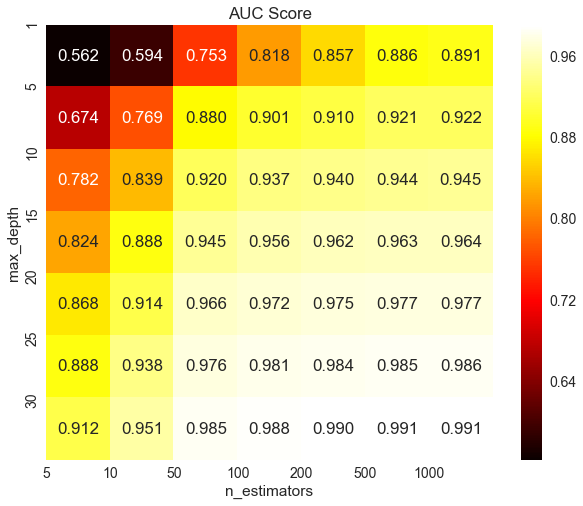

In [62]:
# heat map for train data
#https://github.com/sai977/amazon-fine-food-reviews/blob/master/Amazon%20Fine%20Food%20Reviews%20Analysis%20rf%20and%20gbdt1.ipynb
import seaborn as sns

scores = model.cv_results_['mean_train_score'].reshape(len(base_learners),len(depth))
plt.figure(figsize=(10,8))

sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=base_learners, yticklabels=depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(base_learners)), base_learners)
plt.yticks(np.arange(len(depth)), depth)
plt.title('AUC Score')
plt.show()

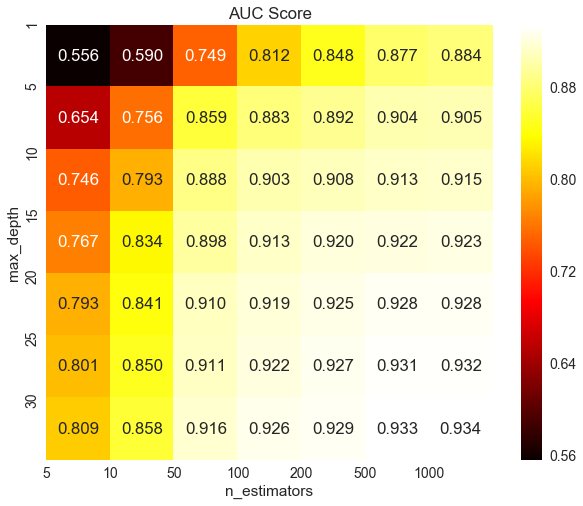

In [63]:
#heatmap for cv data.
#https://github.com/sai977/amazon-fine-food-reviews/blob/master/Amazon%20Fine%20Food%20Reviews%20Analysis%20rf%20and%20gbdt1.ipynb
import seaborn as sns

scores = model.cv_results_['mean_test_score'].reshape(len(base_learners),len(depth))
plt.figure(figsize=(10, 8))

sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=base_learners, yticklabels=depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(base_learners)), base_learners)
plt.yticks(np.arange(len(depth)), depth)
plt.title('AUC Score')
plt.show()

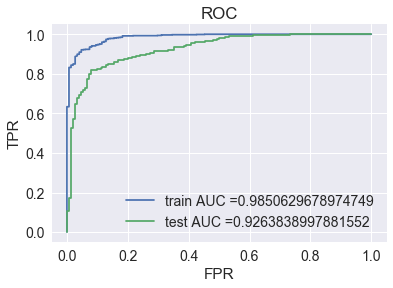

Train confusion matrix
[[ 6534   849]
 [  993 40624]]
Test confusion matrix
[[ 3110  1393]
 [ 1284 24213]]


In [64]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
RF = RandomForestClassifier(max_features='sqrt',class_weight = 'balanced',n_estimators =optimal_learners,max_depth = optimal_depth )
RF.fit(X_tr_tfidf,y_tr)    



for i in range(0,X_tr_tfidf.shape[0],1000):
    train_fpr, train_tpr, thresholds = roc_curve(y_tr[i:i+1000], RF.predict_proba(X_tr_tfidf[i:i+1000])[:,1])

for i in range(0,X_test_tfidf.shape[0],1000):
    test_fpr, test_tpr, thresholds = roc_curve(y_test[i:i+1000], RF.predict_proba(X_test_tfidf[i:i+1000])[:,1])    

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_tr, RF.predict(X_tr_tfidf)))
print("Test confusion matrix")
print(confusion_matrix(y_test, RF.predict(X_test_tfidf)))

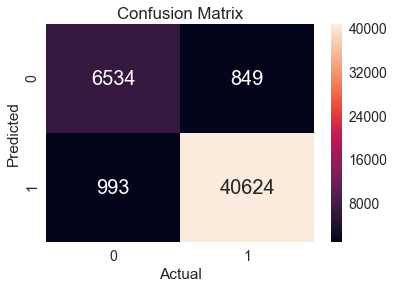

In [65]:
confusion_mtx = pd.DataFrame(confusion_matrix(y_tr, RF.predict(X_tr_tfidf)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion_mtx, annot=True,annot_kws={"size": 20}, fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

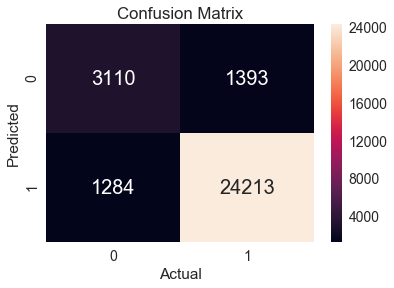

In [66]:
confusion_mtx = pd.DataFrame(confusion_matrix(y_test, RF.predict(X_test_tfidf)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion_mtx, annot=True,annot_kws={"size": 20}, fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

### [5.1.4] Wordcloud of top 20 important features from<font color='red'> SET 2</font>

In [67]:
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

feature_names = tf_idf_vect.get_feature_names()
coefs = sorted(zip(RF.feature_importances_, feature_names))
top = coefs[:-(20 + 1):-1]
for (coef_2, fn_2) in top:
    print("%s    <---------------->     %s"%(coef_2, fn_2))


0.030962591504960866    <---------------->     not
0.02533906054985732    <---------------->     great
0.015314823719943395    <---------------->     best
0.014938615095562572    <---------------->     love
0.011305590499733151    <---------------->     disappointed
0.009976516697301476    <---------------->     perfect
0.009677836651484494    <---------------->     delicious
0.009494497134266786    <---------------->     would
0.00891871877083363    <---------------->     bad
0.008132125069762552    <---------------->     not buy
0.008002652073719353    <---------------->     would not
0.007431702139595348    <---------------->     money
0.007000272826763695    <---------------->     waste
0.006725283525668463    <---------------->     awful
0.0066879289928245145    <---------------->     good
0.006676450911060596    <---------------->     loves
0.006460013712287936    <---------------->     easy
0.006373872761814973    <---------------->     thought
0.006267818215278827    <---------

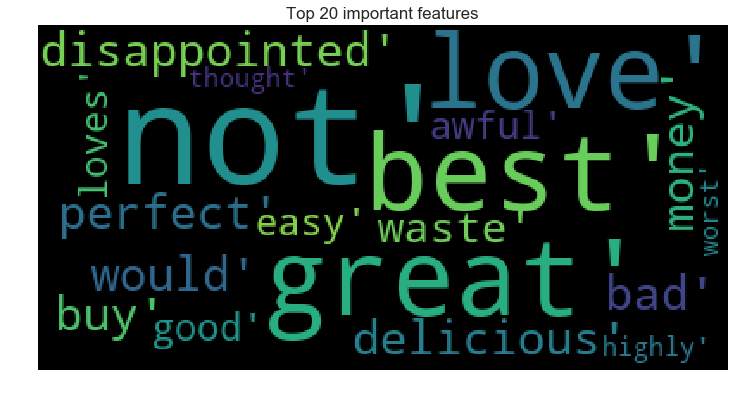

In [68]:
from wordcloud import WordCloud
wordcloud = WordCloud(collocations=False, background_color ='black', 
                min_font_size = 10).generate(str(list(top)))
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Top 20 important features")
plt.show() 

### [5.1.5] Applying Random Forests on AVG W2V,<font color='red'> SET 3</font>

In [196]:
X=preprocessed_RevSum[:100000]
PosNeg = final['Score']
y=PosNeg[:100000]

In [197]:
# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=42)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

In [198]:
# Preparing Reviews for gensim model
i=0
list_of_sentance_train=[]
for sentance in X_tr:
    list_of_sentance_train.append(sentance.split())

In [199]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors


In [200]:
# this line of code trains your w2v model on the give list of sentances
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)

In [201]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  13535
sample words  ['not', 'big', 'tea', 'drinker', 'totally', 'enjoy', 'warm', 'winter', 'summer', 'evenings', 'drink', 'heating', 'microwave', 'mmmmm', 'good', 'yummy', 'toast', 'frying', 'bananas', 'great', 'hands', 'lips', 'like', 'butter', 'need', 'less', 'hoping', 'find', 'nip', 'cats', 'one', 'know', 'care', 'sure', 'either', 'way', 'gets', 'cause', 'small', 'bin', 'dried', 'leaves', 'nothing', 'us', 'cup', 'morning', 'coffee', 'rich', 'flavorful', 'day']


In [202]:
# Converting Reviews into Numerical Vectors using W2V vectors
from tqdm import tqdm
import numpy as np

In [203]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[5])

100%|███████████████████████████████████████████████████████████████████████████| 49000/49000 [02:18<00:00, 353.78it/s]


(49000, 50)
[ 3.36950193e-02 -1.52825812e-01  5.32489419e-01 -2.98364788e-01
  7.56244811e-02 -3.84890292e-01 -4.62663108e-01  4.78275115e-01
  1.05054342e+00  1.01711425e-01  5.43978060e-01  6.56804598e-01
  7.00832475e-01 -1.17148257e+00 -1.18521665e+00  1.41165420e-02
 -9.99762176e-01 -3.92622068e-01 -2.03826294e-01 -8.37122787e-01
 -2.06855377e+00  4.13866455e-01  4.43385442e-03 -1.35545929e-03
 -1.47384868e-01 -2.96466767e-01 -6.38459958e-01 -7.98250661e-01
  1.57980626e-02 -6.60067389e-02  4.81197762e-01  2.34776746e-01
  1.96863795e-01 -1.70589433e+00  6.20064374e-01 -4.94897059e-01
  5.00145421e-01  7.82143493e-02 -5.57097785e-01  6.01053174e-01
 -4.36470691e-01 -5.76053999e-01  1.01469235e+00 -1.60267852e+00
 -5.58118166e-01 -4.02971762e-01 -1.44785271e+00 -1.57411113e-01
  5.05840146e-01  8.97636343e-01]


In [204]:
# Converting CV data text
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

In [205]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

100%|███████████████████████████████████████████████████████████████████████████| 21000/21000 [00:52<00:00, 401.32it/s]


(21000, 50)
[-0.45239354 -0.24602416  0.40364367 -0.54365423 -0.55377407 -0.10999567
  0.12238534  0.64213756  0.94791088 -0.05066463  0.69621902 -0.71216887
  0.64877742 -0.67205744  0.05431934 -0.50266058 -0.93993856  0.81843357
 -0.91947773 -0.70628033 -0.20381604  0.18173235 -0.28343887 -0.22314746
 -0.58909472 -0.93638001 -0.54603347  0.41227731 -0.53580306  0.02066538
  0.35709605  0.42215379  0.11037825 -0.35451185 -0.49185308  0.28270383
  0.82145436 -0.14642273 -0.09395275  0.6961785   0.12790567 -0.35765679
 -0.11868608 -0.8035105   0.15342312 -0.29571177  0.04568292  0.89476099
  0.17935815  0.24561641]


In [206]:
# Converting Test data text
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())


In [207]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [01:14<00:00, 402.17it/s]


(30000, 50)
[-0.41873662 -0.63228885  0.0490611   0.14791253 -0.69964309  0.00977335
 -0.07160429  0.65272877  0.51525008 -0.27795351  0.56424146 -0.64160546
  0.73923072 -0.31480932  0.07615113  0.36886043 -0.41313053  0.92738919
 -0.41996695 -0.75915129 -0.08176532  1.13714576 -0.38912552 -0.46776275
 -0.65877307 -0.45330631  0.19177784  0.22476455 -0.43711037 -0.00715718
  0.02961975  0.05302517  0.41619717  0.01301199  0.11745593  0.24377176
  0.08390838 -0.36398715  0.30781244  0.22221815 -0.21077394 -0.27122865
 -0.28740091 -0.62528727  0.22218924  0.69351212 -0.2190826   0.75666327
 -0.24350576 -0.74112709]


In [208]:
X_tr_w2v = sent_vectors_train
X_cv_w2v = sent_vectors_cv
X_test_w2v = sent_vectors_test

In [82]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

base_learners = [5,10,50,100,200,500,1000]
depth = [1,5,10,15,20,25,30]
tuned_parameters = {'n_estimators': base_learners,'max_depth': depth}
RF = RandomForestClassifier(max_features='sqrt',class_weight = 'balanced')
model = GridSearchCV(RF, tuned_parameters, scoring = 'roc_auc', cv=5 , n_jobs = -1)
model.fit(X_tr_w2v, y_tr)


print(model.best_estimator_)
print("AUC is ",model.score(X_test_w2v, y_test))

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=30, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
AUC is  0.898348384635324


In [83]:
# Optimal value of number of base learners
optimal_learners = model.best_estimator_.n_estimators
print("The optimal number of base learners is : ",optimal_learners)

optimal_depth=model.best_estimator_.max_depth
print("The optimal number of depth is : ",optimal_depth)

The optimal number of base learners is :  1000
The optimal number of depth is :  30


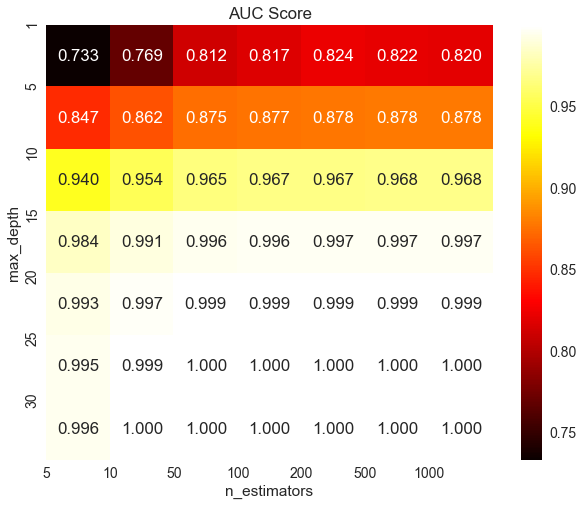

In [84]:
# heat map for train data..#https://github.com/sai977/amazon-fine-food-reviews/blob/master/Amazon%20Fine%20Food%20Reviews%20Analysis%20rf%20and%20gbdt1.ipynb
import seaborn as sns

scores = model.cv_results_['mean_train_score'].reshape(len(base_learners),len(depth))
plt.figure(figsize=(10,8))

sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=base_learners, yticklabels=depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(base_learners)), base_learners)
plt.yticks(np.arange(len(depth)), depth)
plt.title('AUC Score')
plt.show()

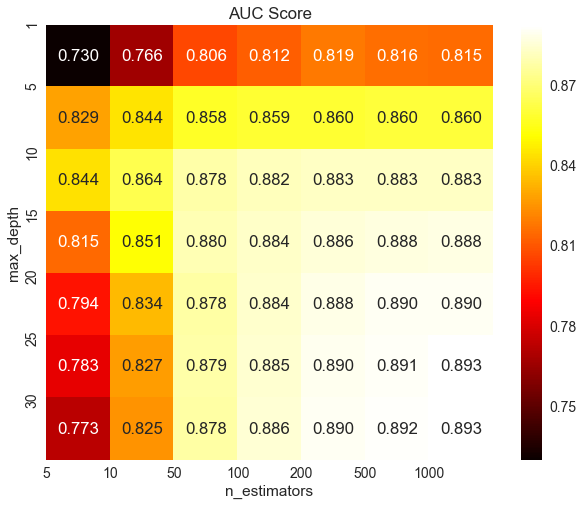

In [85]:
#heatmap for cv data..#https://github.com/sai977/amazon-fine-food-reviews/blob/master/Amazon%20Fine%20Food%20Reviews%20Analysis%20rf%20and%20gbdt1.ipynb
import seaborn as sns

scores = model.cv_results_['mean_test_score'].reshape(len(base_learners),len(depth))
plt.figure(figsize=(10,8))

sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=base_learners, yticklabels=depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(base_learners)), base_learners)
plt.yticks(np.arange(len(depth)), depth)
plt.title('AUC Score')
plt.show()

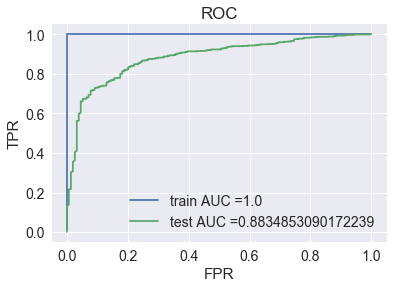

Train confusion matrix
[[ 7520    23]
 [   14 41443]]
Test confusion matrix
[[ 1248  3255]
 [  378 25119]]


In [87]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
RF = RandomForestClassifier(max_features='sqrt',class_weight = 'balanced',n_estimators =optimal_learners,max_depth = optimal_depth )
RF.fit(X_tr_w2v,y_tr)    



for i in range(0,X_tr_w2v.shape[0],1000):
    train_fpr, train_tpr, thresholds = roc_curve(y_tr[i:i+1000], RF.predict_proba(X_tr_w2v[i:i+1000])[:,1])

for i in range(0,X_test_tfidf.shape[0],1000):
    test_fpr, test_tpr, thresholds = roc_curve(y_test[i:i+1000], RF.predict_proba(X_test_w2v[i:i+1000])[:,1])    

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_tr, RF.predict(X_tr_w2v)))
print("Test confusion matrix")
print(confusion_matrix(y_test, RF.predict(X_test_w2v)))

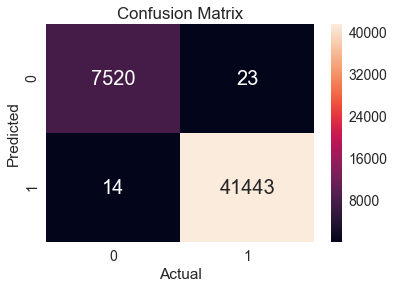

In [88]:
confusion_mtx = pd.DataFrame(confusion_matrix(y_tr, RF.predict(X_tr_w2v)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion_mtx, annot=True,annot_kws={"size": 20}, fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

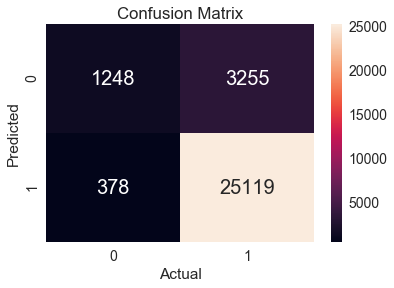

In [89]:
confusion_mtx = pd.DataFrame(confusion_matrix(y_test, RF.predict(X_test_w2v)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion_mtx, annot=True,annot_kws={"size": 20}, fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

### [5.1.6] Applying Random Forests on TFIDF W2V,<font color='red'> SET 4</font>

In [216]:

i=0
list_of_sentance_train=[]
for sentance in X_tr:
    list_of_sentance_train.append(sentance.split())
    

In [217]:
# this line of code trains your w2v model on the give list of sentances
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)

In [218]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors


In [219]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

# Converting Reviews into Numerical Vectors using W2V vectors
from tqdm import tqdm
import numpy as np

# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer(ngram_range=(1,2), min_df=10, dtype=np.float64,max_features = 500)
model.fit(X_tr)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

X_tr2 = model.transform(X_tr)

 #TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

number of words that occured minimum 5 times  13535
sample words  ['not', 'big', 'tea', 'drinker', 'totally', 'enjoy', 'warm', 'winter', 'summer', 'evenings', 'drink', 'heating', 'microwave', 'mmmmm', 'good', 'yummy', 'toast', 'frying', 'bananas', 'great', 'hands', 'lips', 'like', 'butter', 'need', 'less', 'hoping', 'find', 'nip', 'cats', 'one', 'know', 'care', 'sure', 'either', 'way', 'gets', 'cause', 'small', 'bin', 'dried', 'leaves', 'nothing', 'us', 'cup', 'morning', 'coffee', 'rich', 'flavorful', 'day']


100%|███████████████████████████████████████████████████████████████████████████| 49000/49000 [02:35<00:00, 314.32it/s]


In [220]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

In [221]:
X_cv2 = model.transform(X_cv)

In [222]:
#TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 21000/21000 [01:01<00:00, 340.40it/s]


In [223]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [224]:
X_test2 = model.transform(X_test)

In [225]:
 #TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [01:26<00:00, 347.91it/s]


In [226]:
X_tr2 = tfidf_sent_vectors_train
X_cv2 = tfidf_sent_vectors_cv
X_test2 = tfidf_sent_vectors_test

X_tr_tfidf_w2v = np.array(X_tr2)
X_cv_tfidf_w2v = np.array(X_cv2)
X_test_tfidf_w2v = np.array(X_test2)

In [101]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


base_learners = [5,10,50,100,200,500,1000]
depth = [1,5,10,15,20,25,30]
tuned_parameters = {'n_estimators': base_learners,'max_depth': depth}
RF = RandomForestClassifier(max_features='sqrt',class_weight = 'balanced')
model = GridSearchCV(RF, tuned_parameters, scoring = 'roc_auc', cv=5 , n_jobs = -1)
model.fit(X_tr_tfidf_w2v, y_tr)


print(model.best_estimator_)
print("AUC is ",model.score(X_test_tfidf_w2v, y_test))

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=30, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
AUC is  0.849835137558606


In [102]:
# Optimal value of number of base learners
optimal_learners = model.best_estimator_.n_estimators
print("The optimal number of base learners is : ",optimal_learners)

optimal_depth=model.best_estimator_.max_depth
print("The optimal number of depth is : ",optimal_depth)

The optimal number of base learners is :  1000
The optimal number of depth is :  30


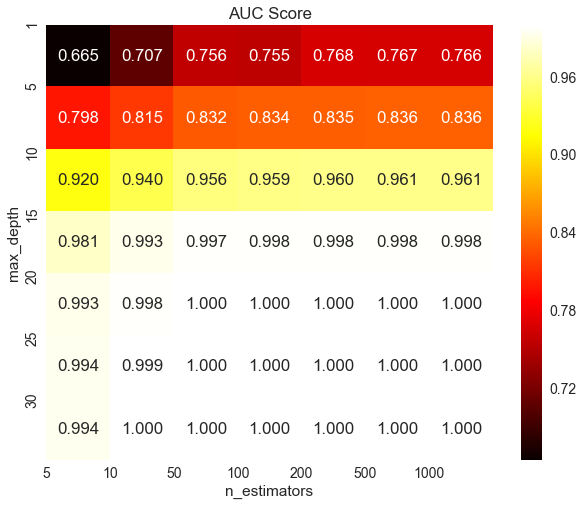

In [103]:
# heat map for train data
import seaborn as sns

scores = model.cv_results_['mean_train_score'].reshape(len(base_learners),len(depth))
plt.figure(figsize=(10,8))

sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=base_learners, yticklabels=depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(base_learners)), base_learners)
plt.yticks(np.arange(len(depth)), depth)
plt.title('AUC Score')
plt.show()

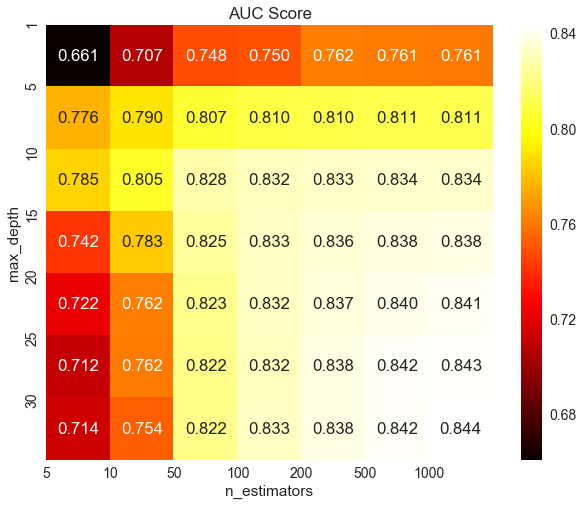

In [104]:
import seaborn as sns

scores = model.cv_results_['mean_test_score'].reshape(len(base_learners),len(depth))
plt.figure(figsize=(10,8))

sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=base_learners, yticklabels=depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(base_learners)), base_learners)
plt.yticks(np.arange(len(depth)), depth)
plt.title('AUC Score')
plt.show()

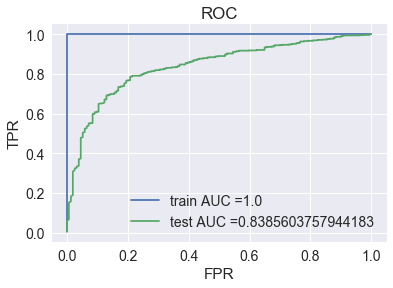

Train confusion matrix
[[ 7519    24]
 [    1 41456]]
Test confusion matrix
[[  580  3923]
 [  239 25258]]


In [105]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
RF = RandomForestClassifier(max_features='sqrt',class_weight = 'balanced',n_estimators =optimal_learners,max_depth = optimal_depth )
RF.fit(X_tr_tfidf_w2v,y_tr)    



for i in range(0,X_tr_tfidf_w2v.shape[0],1000):
    train_fpr, train_tpr, thresholds = roc_curve(y_tr[i:i+1000], RF.predict_proba(X_tr_tfidf_w2v[i:i+1000])[:,1])

for i in range(0,X_test_tfidf_w2v.shape[0],1000):
    test_fpr, test_tpr, thresholds = roc_curve(y_test[i:i+1000], RF.predict_proba(X_test_tfidf_w2v[i:i+1000])[:,1])    

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_tr, RF.predict(X_tr_tfidf_w2v)))
print("Test confusion matrix")
print(confusion_matrix(y_test, RF.predict(X_test_tfidf_w2v)))

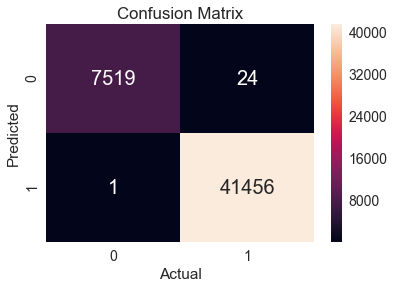

In [106]:
confusion_mtx = pd.DataFrame(confusion_matrix(y_tr, RF.predict(X_tr_tfidf_w2v)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion_mtx, annot=True,annot_kws={"size": 20}, fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

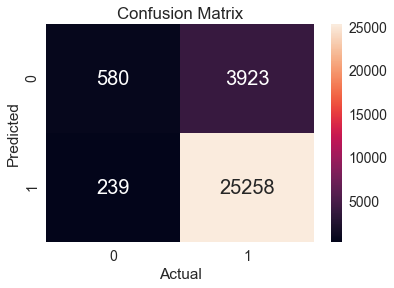

In [107]:
confusion_mtx = pd.DataFrame(confusion_matrix(y_test, RF.predict(X_test_tfidf_w2v)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion_mtx, annot=True,annot_kws={"size": 20}, fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

## [5.2] Applying GBDT using XGBOOST

### [5.2.1] Applying XGBOOST on BOW,<font color='red'> SET 1</font>

In [177]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV


base_learners = [5,10,50,100,200,300,500,700,1000]
depth = [2,3,4,5,6,7,8,9,10]
tuned_parameters = {'n_estimators':base_learners, 'max_depth':depth}
gbdt = xgb.XGBClassifier(booster='gbtree')    
model = GridSearchCV(gbdt,tuned_parameters,scoring='roc_auc',n_jobs=-1)
model.fit(X_tr_bow,y_tr)

print(model.best_estimator_)
print("AUC is ",model.score(X_test_bow, y_test))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=1, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)
AUC is  0.9513606086614361


In [178]:
# Optimal value of number of base learners
optimal_learners = model.best_estimator_.n_estimators
print("The optimal number of base learners is : ",optimal_learners)

optimal_depth=model.best_estimator_.max_depth
print("The optimal  depth is : ",optimal_depth)

The optimal number of base learners is :  1000
The optimal  depth is :  7


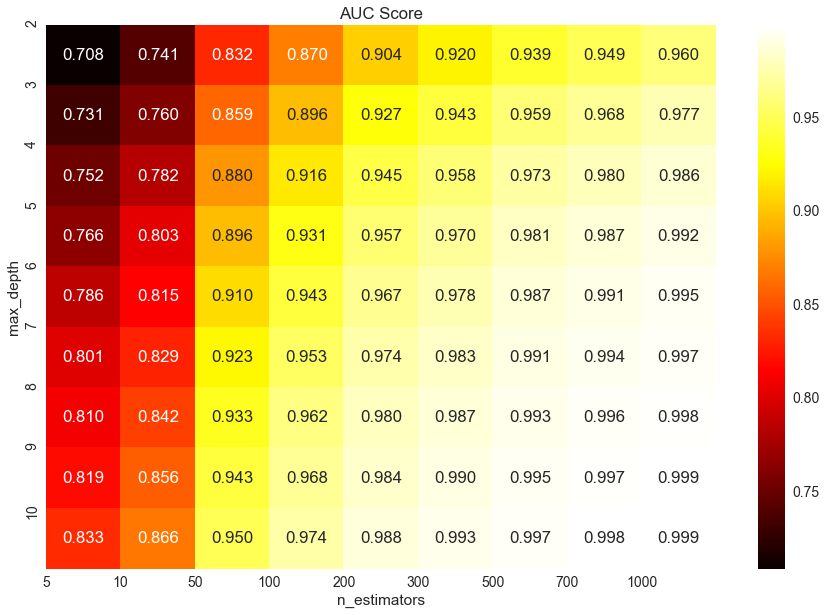

In [185]:
#heat map for train data
import seaborn as sns

scores = model.cv_results_['mean_train_score'].reshape(len(base_learners),len(depth))
plt.figure(figsize=(15,10))

sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=base_learners, yticklabels=depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(base_learners)), base_learners)
plt.yticks(np.arange(len(depth)), depth)
plt.title('AUC Score')
plt.show()

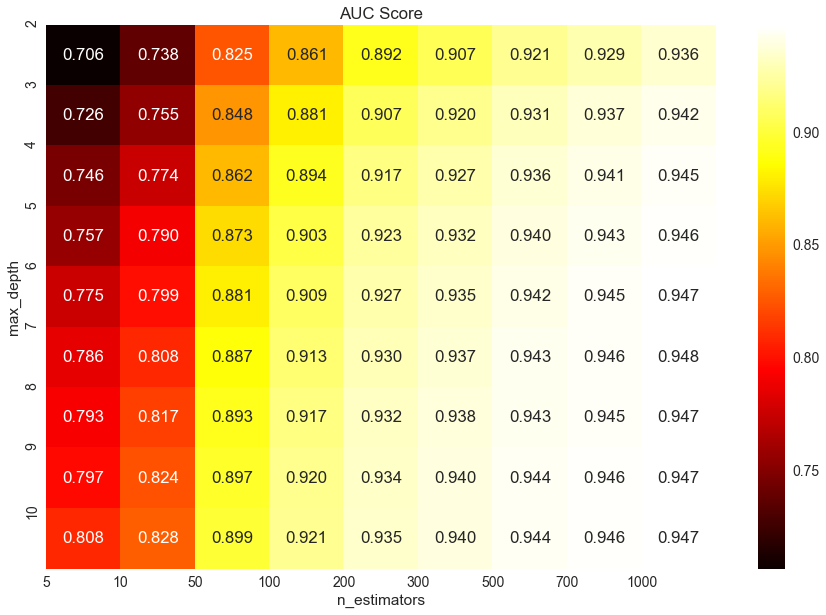

In [184]:
#heat map for cross validation data
import seaborn as sns

scores = model.cv_results_['mean_test_score'].reshape(len(base_learners),len(depth))
plt.figure(figsize=(15,10))

sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=base_learners, yticklabels=depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(base_learners)), base_learners)
plt.yticks(np.arange(len(depth)), depth)
plt.title('AUC Score')
plt.show()

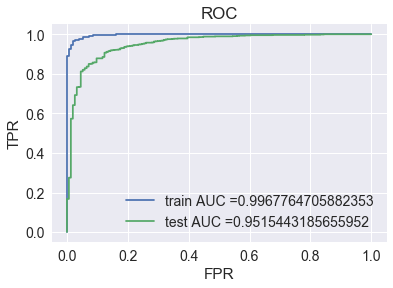

Train confusion matrix
[[ 6286  1161]
 [  108 41445]]
Test confusion matrix
[[ 2798  1705]
 [  489 25008]]


In [181]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
gbdt = xgb.XGBClassifier(booster='gbtree',n_estimators =optimal_learners,max_depth = optimal_depth)    

gbdt.fit(X_tr_bow,y_tr)    



for i in range(0,X_tr_bow.shape[0],1000):
    train_fpr, train_tpr, thresholds = roc_curve(y_tr[i:i+1000], gbdt.predict_proba(X_tr_bow[i:i+1000])[:,1])

for i in range(0,X_test_bow.shape[0],1000):
    test_fpr, test_tpr, thresholds = roc_curve(y_test[i:i+1000], gbdt.predict_proba(X_test_bow[i:i+1000])[:,1])    

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_tr, gbdt.predict(X_tr_bow)))
print("Test confusion matrix")
print(confusion_matrix(y_test, gbdt.predict(X_test_bow)))

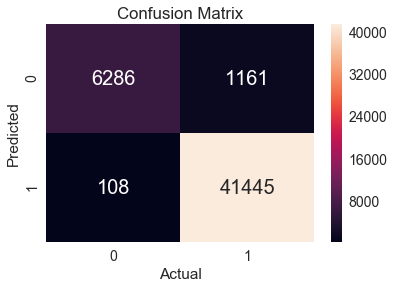

In [182]:
confusion_mtx = pd.DataFrame(confusion_matrix(y_tr, gbdt.predict(X_tr_bow)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion_mtx, annot=True,annot_kws={"size": 20}, fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

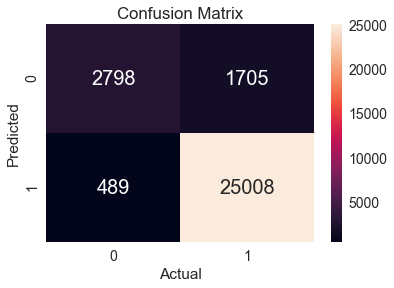

In [183]:
confusion_mtx = pd.DataFrame(confusion_matrix(y_test, gbdt.predict(X_test_bow)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion_mtx, annot=True,annot_kws={"size": 20}, fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

### [5.2.2] Applying XGBOOST on TFIDF,<font color='red'> SET 2</font>

In [189]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
base_learners = [5,10,50,100,200,300,500,700,1000]
depth = [2,3,4,5,6,7,8,9,10]
tuned_parameters = {'n_estimators':base_learners, 'max_depth':depth}
gbdt = xgb.XGBClassifier(booster='gbtree')    
model = GridSearchCV(gbdt,tuned_parameters,scoring='roc_auc',n_jobs=-1)
model.fit(X_tr_tfidf,y_tr)

print(model.best_estimator_)
print("AUC is ",model.score(X_test_tfidf, y_test))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=1, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)
AUC is  0.952919326002055


In [190]:
# Optimal value of number of base learners
optimal_learners = model.best_estimator_.n_estimators
print("The optimal number of base learners is : ",optimal_learners)

optimal_depth=model.best_estimator_.max_depth
print("The optimal depth is : ",optimal_depth)

The optimal number of base learners is :  1000
The optimal depth is :  7


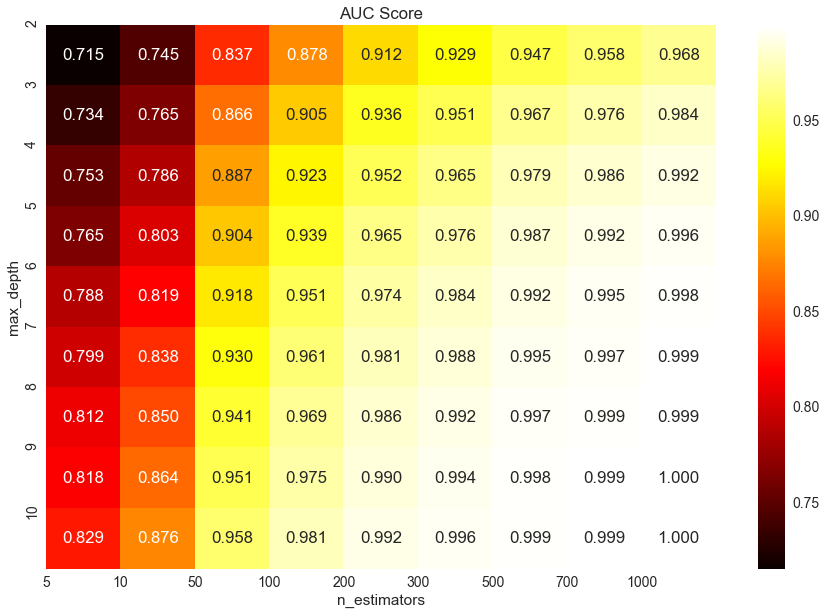

In [191]:
# heat map for train data
import seaborn as sns

scores = model.cv_results_['mean_train_score'].reshape(len(base_learners),len(depth))
plt.figure(figsize=(15,10))

sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=base_learners, yticklabels=depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(base_learners)), base_learners)
plt.yticks(np.arange(len(depth)), depth)
plt.title('AUC Score')
plt.show()

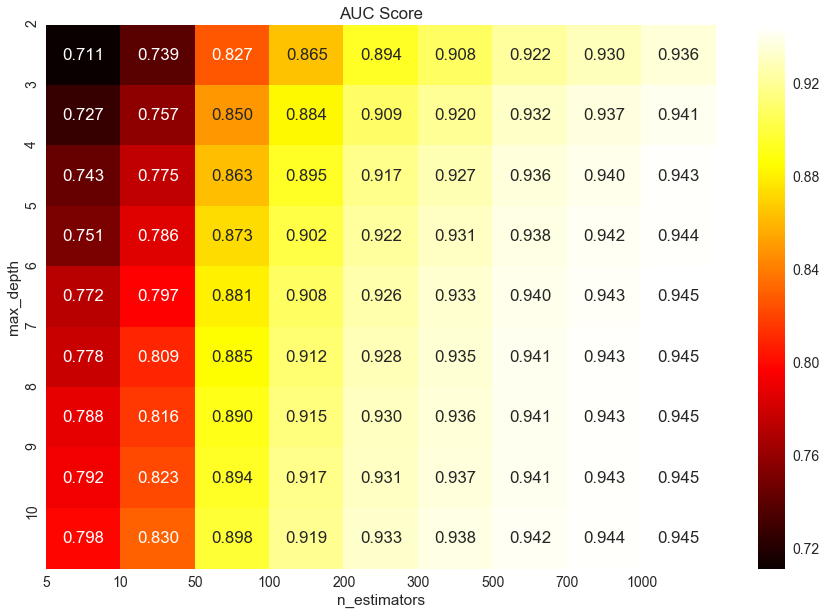

In [192]:
#heat map for cv data
import seaborn as sns

scores = model.cv_results_['mean_test_score'].reshape(len(base_learners),len(depth))
plt.figure(figsize=(15,10))

sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=base_learners, yticklabels=depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(base_learners)), base_learners)
plt.yticks(np.arange(len(depth)), depth)
plt.title('AUC Score')
plt.show()

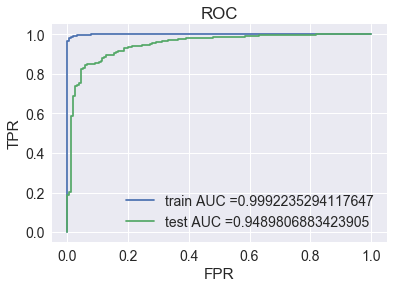

Train confusion matrix
[[ 6635   812]
 [   66 41487]]
Test confusion matrix
[[ 2721  1782]
 [  456 25041]]


In [193]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
gbdt = xgb.XGBClassifier(booster='gbtree',n_estimators =optimal_learners,max_depth = optimal_depth)    

gbdt.fit(X_tr_tfidf,y_tr)    



for i in range(0,X_tr_tfidf.shape[0],1000):
    train_fpr, train_tpr, thresholds = roc_curve(y_tr[i:i+1000], gbdt.predict_proba(X_tr_tfidf[i:i+1000])[:,1])

for i in range(0,X_test_tfidf.shape[0],1000):
    test_fpr, test_tpr, thresholds = roc_curve(y_test[i:i+1000], gbdt.predict_proba(X_test_tfidf[i:i+1000])[:,1])    

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_tr, gbdt.predict(X_tr_tfidf)))
print("Test confusion matrix")
print(confusion_matrix(y_test, gbdt.predict(X_test_tfidf)))

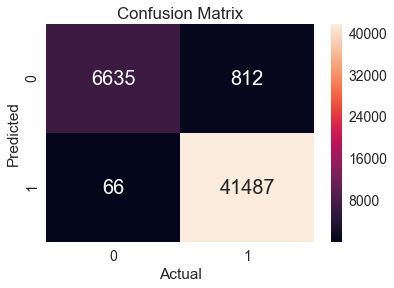

In [194]:
confusion_mtx = pd.DataFrame(confusion_matrix(y_tr, gbdt.predict(X_tr_tfidf)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion_mtx, annot=True,annot_kws={"size": 20}, fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

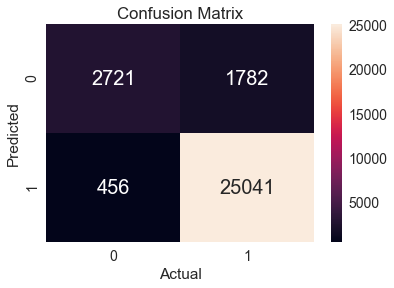

In [195]:
confusion_mtx = pd.DataFrame(confusion_matrix(y_test, gbdt.predict(X_test_tfidf)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion_mtx, annot=True,annot_kws={"size": 20}, fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

### [5.2.3] Applying XGBOOST on AVG W2V,<font color='red'> SET 3</font>

In [209]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
base_learners = [5,10,50,100,200,300,500,700,1000]
depth = [2,3,4,5,6,7,8,9,10]

tuned_parameters = {'n_estimators': base_learners,'max_depth': depth}
gbdt = xgb.XGBClassifier(booster='gbtree')    
model = GridSearchCV(gbdt, tuned_parameters, scoring = 'roc_auc', cv=5 , n_jobs = -1)
model.fit(X_tr_w2v, y_tr)


print(model.best_estimator_)
print("AUC is ",model.score(X_test_w2v, y_test))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)
AUC is  0.911186491953685


In [210]:
# Optimal value of number of base learners
optimal_learners = model.best_estimator_.n_estimators
print("The optimal number of base learners is : ",optimal_learners)

optimal_depth=model.best_estimator_.max_depth
print("The optimal depth is : ",optimal_depth)

The optimal number of base learners is :  1000
The optimal depth is :  10


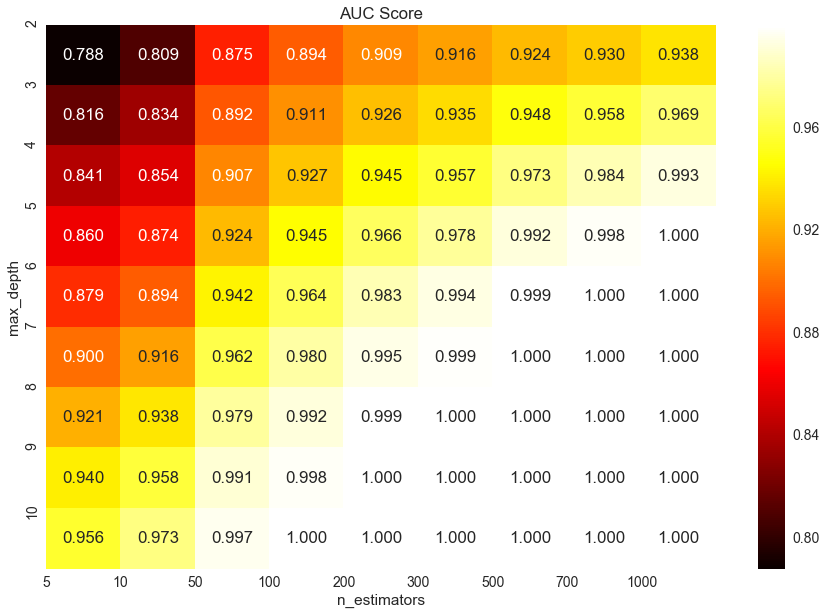

In [211]:
#heatmap for train data
import seaborn as sns

scores = model.cv_results_['mean_train_score'].reshape(len(base_learners),len(depth))
plt.figure(figsize=(15,10))

sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=base_learners, yticklabels=depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(base_learners)), base_learners)
plt.yticks(np.arange(len(depth)), depth)
plt.title('AUC Score')
plt.show()

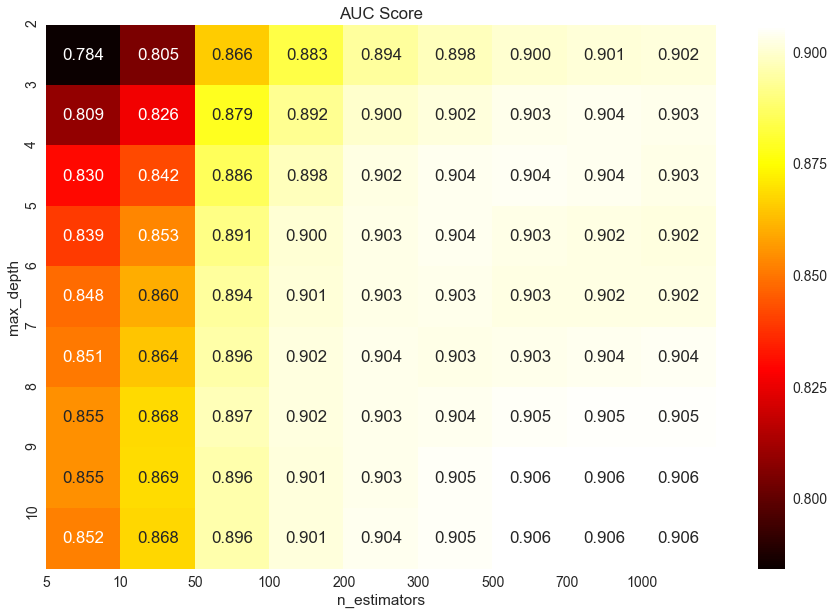

In [212]:
#heatmap for cv data
import seaborn as sns

scores = model.cv_results_['mean_test_score'].reshape(len(base_learners),len(depth))
plt.figure(figsize=(15,10))

sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=base_learners, yticklabels=depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(base_learners)), base_learners)
plt.yticks(np.arange(len(depth)), depth)
plt.title('AUC Score')
plt.show()

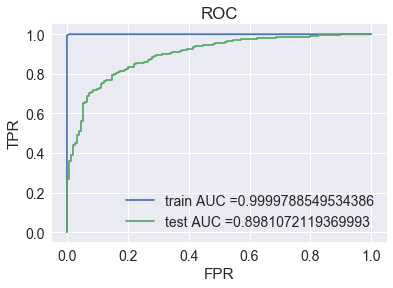

Train confusion matrix
[[ 7462    26]
 [    0 41512]]
Test confusion matrix
[[ 2128  2375]
 [  732 24765]]


In [213]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
gbdt = xgb.XGBClassifier(booster='gbtree',n_estimators =optimal_learners,max_depth = optimal_depth) 
gbdt.fit(X_tr_w2v,y_tr)    



for i in range(0,X_tr_w2v.shape[0],1000):
    train_fpr, train_tpr, thresholds = roc_curve(y_tr[i:i+1000], gbdt.predict_proba(X_tr_w2v[i:i+1000])[:,1])

for i in range(0,X_test_w2v.shape[0],1000):
    test_fpr, test_tpr, thresholds = roc_curve(y_test[i:i+1000], gbdt.predict_proba(X_test_w2v[i:i+1000])[:,1])    

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_tr, gbdt.predict(X_tr_w2v)))
print("Test confusion matrix")
print(confusion_matrix(y_test, gbdt.predict(X_test_w2v)))

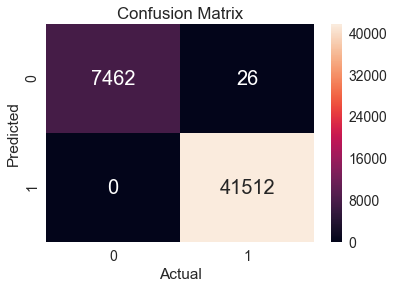

In [214]:
confusion_mtx = pd.DataFrame(confusion_matrix(y_tr, gbdt.predict(X_tr_w2v)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion_mtx, annot=True,annot_kws={"size": 20}, fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

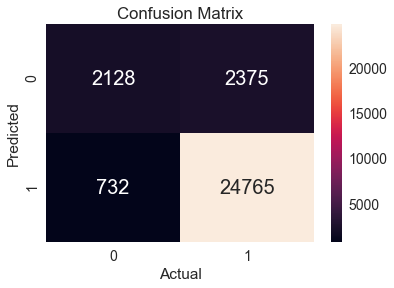

In [215]:
confusion_mtx = pd.DataFrame(confusion_matrix(y_test, gbdt.predict(X_test_w2v)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion_mtx, annot=True,annot_kws={"size": 20}, fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

### [5.2.4] Applying XGBOOST on TFIDF W2V,<font color='red'> SET 4</font>

In [227]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

base_learners = [5,10,50,100,200,300,500,700,1000]
depth = [2,3,4,5,6,7,8,9,10]
tuned_parameters = {'n_estimators': base_learners,'max_depth': depth}
gbdt = xgb.XGBClassifier(booster='gbtree')    
model = GridSearchCV(gbdt, tuned_parameters, scoring = 'roc_auc', cv=5 , n_jobs = -1)
model.fit(X_tr_tfidf_w2v, y_tr)


print(model.best_estimator_)
print("AUC is ",model.score(X_test_tfidf_w2v, y_test))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)
AUC is  0.8624199416597378


In [228]:
# Optimal value of number of base learners
optimal_learners = model.best_estimator_.n_estimators
print("The optimal number of base learners is : ",optimal_learners)

optimal_depth=model.best_estimator_.max_depth
print("The optimal depth is : ",optimal_depth)

The optimal number of base learners is :  1000
The optimal depth is :  10


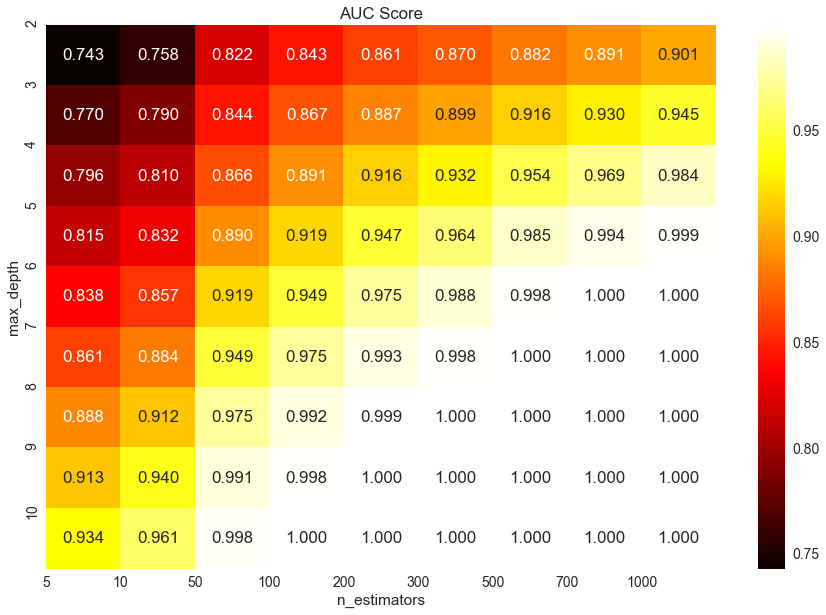

In [229]:
#heatmap for train data
import seaborn as sns

scores = model.cv_results_['mean_train_score'].reshape(len(base_learners),len(depth))
plt.figure(figsize=(15,10))

sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=base_learners, yticklabels=depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(base_learners)), base_learners)
plt.yticks(np.arange(len(depth)), depth)
plt.title('AUC Score')
plt.show()

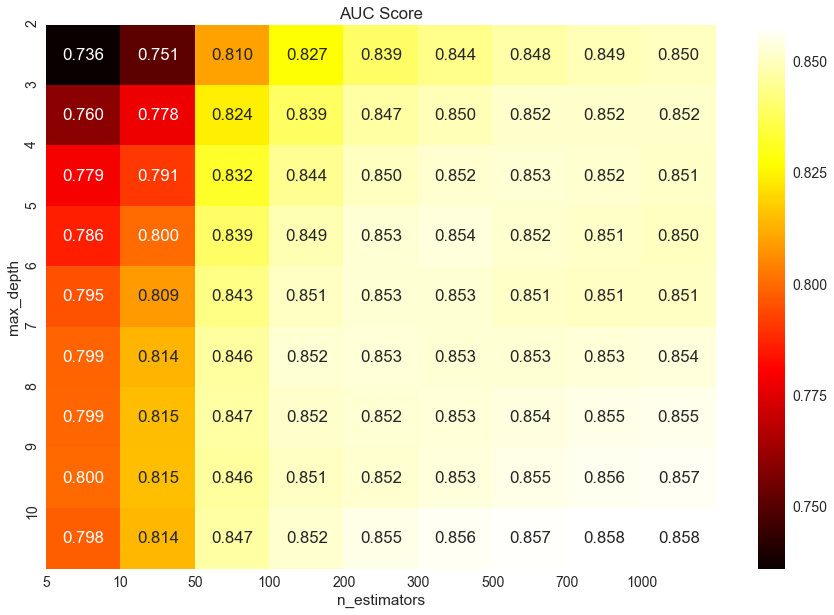

In [230]:
#heat map for cv data
import seaborn as sns

scores = model.cv_results_['mean_test_score'].reshape(len(base_learners),len(depth))
plt.figure(figsize=(15,10))

sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=base_learners, yticklabels=depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(base_learners)), base_learners)
plt.yticks(np.arange(len(depth)), depth)
plt.title('AUC Score')
plt.show()

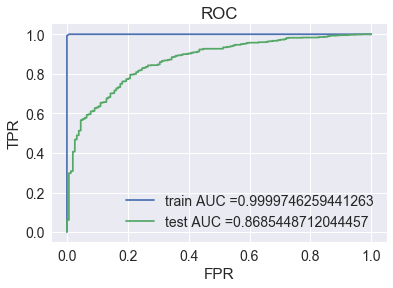

Train confusion matrix
[[ 7460    28]
 [    0 41512]]
Test confusion matrix
[[ 1454  3049]
 [  682 24815]]


In [231]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
gbdt = xgb.XGBClassifier(booster='gbtree',n_estimators =optimal_learners,max_depth = optimal_depth)    

gbdt.fit(X_tr_tfidf_w2v,y_tr)    



for i in range(0,X_tr_tfidf_w2v.shape[0],1000):
    train_fpr, train_tpr, thresholds = roc_curve(y_tr[i:i+1000], gbdt.predict_proba(X_tr_tfidf_w2v[i:i+1000])[:,1])

for i in range(0,X_test_tfidf_w2v.shape[0],1000):
    test_fpr, test_tpr, thresholds = roc_curve(y_test[i:i+1000], gbdt.predict_proba(X_test_tfidf_w2v[i:i+1000])[:,1])    

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_tr, gbdt.predict(X_tr_tfidf_w2v)))
print("Test confusion matrix")
print(confusion_matrix(y_test, gbdt.predict(X_test_tfidf_w2v)))

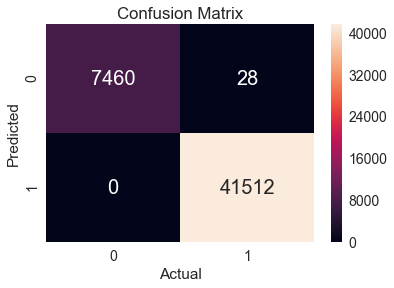

In [232]:
confusion_mtx = pd.DataFrame(confusion_matrix(y_tr, gbdt.predict(X_tr_tfidf_w2v)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion_mtx, annot=True,annot_kws={"size": 20}, fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

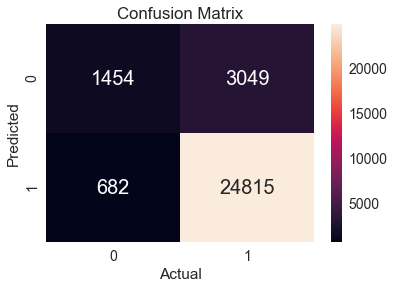

In [233]:
confusion_mtx = pd.DataFrame(confusion_matrix(y_test, gbdt.predict(X_test_tfidf_w2v)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion_mtx, annot=True,annot_kws={"size": 20}, fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

# [6] Conclusions

In [234]:
from prettytable import PrettyTable
PTable = PrettyTable()
PTable.field_names = ["Vectorizor","Model" ,"Hyperparameter--max_depth" , "Hyperparameter--n_estimators","Test-AUC","Train-AUC"]

In [235]:
PTable.add_row(['BoW','RF',25,1000,0.93,0.96])
PTable.add_row(['TF-IDF','RF',30,1000,0.93,0.98])
PTable.add_row(['AVG-W2V','RF',30,1000,0.89,1.0])
PTable.add_row(['TFIDF_W2V','RF',30,1000,0.84,1.0])
print(PTable)

+------------+-------+---------------------------+------------------------------+----------+-----------+
| Vectorizor | Model | Hyperparameter--max_depth | Hyperparameter--n_estimators | Test-AUC | Train-AUC |
+------------+-------+---------------------------+------------------------------+----------+-----------+
|    BoW     |   RF  |             25            |             1000             |   0.93   |    0.96   |
|   TF-IDF   |   RF  |             30            |             1000             |   0.93   |    0.98   |
|  AVG-W2V   |   RF  |             30            |             1000             |   0.89   |    1.0    |
| TFIDF_W2V  |   RF  |             30            |             1000             |   0.84   |    1.0    |
+------------+-------+---------------------------+------------------------------+----------+-----------+


In [236]:
PTable1 = PrettyTable()
PTable1.field_names = ["Vectorizor","Model", "Hyperparameter--max_depth"  ,"Hyperparameter--n_estimators","Test-AUC","Train-AUC"]

In [237]:
PTable1.add_row(['BoW','GBDT',7,1000,0.95,0.99])
PTable1.add_row(['TF-IDF','GBDT',7,1000,0.95,0.99])
PTable1.add_row(['AVG-W2V','GBDT',10,1000,0.91,0.99])
PTable1.add_row(['TFIDF_W2V','GBDT',10,1000,0.86,0.99])
print(PTable1)

+------------+-------+---------------------------+------------------------------+----------+-----------+
| Vectorizor | Model | Hyperparameter--max_depth | Hyperparameter--n_estimators | Test-AUC | Train-AUC |
+------------+-------+---------------------------+------------------------------+----------+-----------+
|    BoW     |  GBDT |             7             |             1000             |   0.95   |    0.99   |
|   TF-IDF   |  GBDT |             7             |             1000             |   0.95   |    0.99   |
|  AVG-W2V   |  GBDT |             10            |             1000             |   0.91   |    0.99   |
| TFIDF_W2V  |  GBDT |             10            |             1000             |   0.86   |    0.99   |
+------------+-------+---------------------------+------------------------------+----------+-----------+


*From the above table, TFIDF_W2V got less AUC score compared to other featurizations.*

# Procedure

* First I loaded the data from SQLite Database.

2. Data Cleaning: 
Deduplication - duplicates are removed

3. Preprocessing: 
It is done to remove html tags, punctuations or limited set of special characters ,Stopwords etc.
Preprocessing is performed on review text and summary text.


* In this analysis Random Forest and GBDT is applied on Bag of Words,TF-IDF,Avg-W2v,TFIDF-W2v vectorizers.
2. Firstly I created new dataframe (df1), where i used only preprocessed review and preprocessed summary text as a seperate column.
3. For each reviews I created a new feature - length(which computes length of review text).
4. Then I created a new column for length feature in the dataframe.
5. Considering only 100k data points I spllited the data into 3 parts -Train,Cv,Test.
6. Fitted the RandomForest and XGboost classifiers on D_train data.
7. Using Gridsearchcv,I computed best hyperparameter(*'max_depth and n_estimators'*) for each featurization.
12. The plotted Heatmaps(To know the performance of model both on train data and cross validation data for each hyper parameter) and Auc plots.
11. Then computed top 20 importan features for BOW and Tfidf.
13. Confusion matrix (for both train and test)is obtained for every featurizations.
14. We can further improve the model by taking more data points, and by taking some other features that may provide us with better insight about the data.
 